In [1]:
import pandas as pd
import numpy as np

In [6]:
data = pd.read_csv('clean_data.csv', index_col='Unnamed: 0')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Label encoding
<code>Fare</code>: 0, 1, 2 depending on how expensive (clustering using KMeans)\
<code>PClass</code>: 1, 2, 3 $\rightarrow$ 0, 1, 2\
<code>Age</code> $\rightarrow$ 0 - childhood (0 - 15), 1 - adult (15 - 55), 2 - old (> 55)\
<code>Cabin</code>: 0 (null), 1 (not null)\
<code>Sex</code>: male, female $\rightarrow$ 0, 1

## Encoding <code>Fare</code>

In [17]:
from sklearn.cluster import KMeans

In [27]:
fare = data['Fare'].values
clf = KMeans(n_clusters=3).fit(fare.reshape(-1, 1))
fare_clf = clf.predict(fare.reshape(-1, 1))

In [62]:
comp = pd.DataFrame(zip(fare, fare_clf), columns=['Old', 'New'])

In [69]:
# comp[comp.New == 0].describe()
# Class 0: min 0, max 47.1, mean 15.3, total count: 1061
# comp[comp.New == 1].describe()
# Class 1: min 211.3, max 512.3, mean 266.7, total count: 38
# comp[comp.New == 2].describe()
# Class 2: min 49.5, max 164.9, mean 82.8, total count: 207

,Old,New
count,207.000000,207.0
mean,82.760729,2.0
std,30.669238,0.0
min,49.500000,2.0
25%,57.750000,2.0
50%,75.250000,2.0
75%,90.539600,2.0
max,164.866700,2.0


In [70]:
data['Fare'] = fare_clf

## Encoding <code>Pclass</code>

In [73]:
data['Pclass'] = data['Pclass'] - 1

## Encoding <code>Age</code>

In [84]:
len(data[data.Age < 15]) + len(data[(data.Age >= 15) & (data.Age < 55)]) + len(data[data.Age >= 55]) == len(data)

True

In [85]:
data.loc[data.Age < 15,'Age'] = 0
data.loc[(data.Age >= 15) & (data.Age < 55), 'Age'] = 1
data.loc[data.Age >= 55, 'Age'] = 2

In [88]:
len(data[data.Age == 0]) + len(data[data.Age == 1]) + len(data[data.Age == 2]) == len(data)

True

## Encoding <code>Cabin</code>

In [89]:
data.loc[data.Cabin.isnull(), 'Cabin'] = 0
data.loc[data.Cabin.notnull(), 'Cabin'] = 1

In [90]:
len(data[data.Cabin == 0]) + len(data[data.Cabin == 1]) == len(data)

True

## Encoding <code>Sex</code>

In [91]:
data.loc[data.Sex == 'male', 'Sex'] = 0
data.loc[data.Sex == 'female', 'Sex'] = 1

In [92]:
len(data[data.Sex == 0]) + len(data[data.Sex == 1]) == len(data)

True

## Dropping unused columns

In [94]:
to_drop = ['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Embarked']
final = data.drop(columns = to_drop, axis=1)

In [97]:
final.Age = final.Age.astype(int)
final

,Survived,Pclass,Sex,Age,Fare,Cabin
0,0,2,0,1,0,1
1,1,0,1,1,2,1
2,1,2,1,1,0,1
3,1,0,1,1,2,1
4,0,2,0,1,0,1
...,...,...,...,...,...,...
1301,0,2,0,1,0,1
1302,1,0,1,1,2,1
1303,0,2,0,1,0,1
1304,0,2,0,1,0,1


## Building model

<img src="model.jpg">

In [142]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator
import pgmpy.inference
import networkx as nx
import pylab as plt

In [270]:
model = BayesianModel([('Fare', 'Pclass'),
                       ('Pclass', 'Survived'),
                       ('Age', 'Survived'),
                       ('Cabin', 'Survived'),
                       ('Sex', 'Survived')])

Finding Elimination Order: : 100%|██████████| 4/4 [09:24<00:00, 141.19s/it]


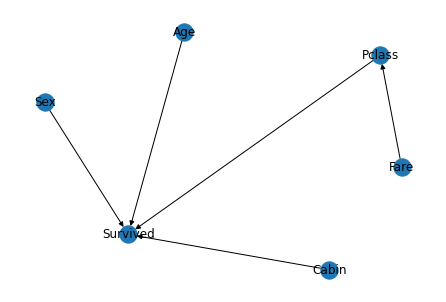

In [271]:
nx.draw(model, with_labels=True)

## Training and evaluating model

In [166]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate, cross_val_score

### One time

In [155]:
X_train, X_test, y_train, y_test = train_test_split(final, final, test_size=0.2, random_state=42)

In [255]:
model.fit(X_train, estimator=BayesianEstimator, prior_type="BDeu")

In [256]:
test_data = X_test.drop(columns=['Survived'], axis=1)
y_pred = model.predict(test_data)

100%|██████████| 23/23 [00:00<00:00, 187.86it/s]


In [257]:
accuracy_score(y_pred['Survived'], X_test['Survived'])

0.8396946564885496

In [268]:
from pgmpy.inference import VariableElimination
model_infer = VariableElimination(model)
q = model_infer.query(variables=['Survived'], evidence={'Sex': 1})
print(q)






  0%|          | 0/4 [00:00<?, ?it/s]




Finding Elimination Order: :   0%|          | 0/4 [00:00<?, ?it/s]






  0%|          | 0/4 [00:00<?, ?it/s]






Eliminating: Fare:   0%|          | 0/4 [00:00<?, ?it/s]






Eliminating: Cabin:   0%|          | 0/4 [00:00<?, ?it/s]






Eliminating: Age:   0%|          | 0/4 [00:00<?, ?it/s]  






Eliminating: Pclass: 100%|██████████| 4/4 [00:00<00:00, 329.22it/s]

+-------------+-----------------+
| Survived    |   phi(Survived) |
+=============+=================+
| Survived(0) |          0.1962 |
+-------------+-----------------+
| Survived(1) |          0.8038 |
+-------------+-----------------+


### 10-fold cross validation

In [168]:
# cv = cross_validate(model, X, y, cv=10, scoring='accuracy')
# cv = cross_val_score(model, X, y, cv=10, scoring='accuracy')

In [272]:
def partition(data, n):
    splits = []
    remaining = data.copy(deep=True)
    for i in range(n):
        split = remaining.sample(frac=1/(n-i), random_state=10)
        splits.append(split)
        remaining = remaining.drop(split.index)
    return splits

In [273]:
def cross_val(model, data, n, target):
    scores = []
    splits = partition(data, n)
    for i in range(n):
        train_list = splits[:i] + splits[i+1:]
        train = pd.concat(train_list)
        test = splits[i]
        y_true = test[target]
        test = test.drop(columns=[target], axis=1)
        model.fit(train, estimator=BayesianEstimator, prior_type="BDeu")
        y_pred = model.predict(test)
        acc = accuracy_score(y_pred[target], y_true)
        scores.append(acc)
    return scores

In [274]:
scores = cross_val(model, final, 10, target="Survived")

100%|██████████| 23/23 [00:00<00:00, 695.77it/s]


In [275]:
print("Mean score:", np.mean(scores))
scores

Mean score: 0.8468115091015853


[0.9007633587786259,
 0.8244274809160306,
 0.8769230769230769,
 0.8473282442748091,
 0.8076923076923077,
 0.8549618320610687,
 0.8,
 0.8549618320610687,
 0.8384615384615385,
 0.8625954198473282]

### Experimenting with sampling

In [182]:
split0 = final.sample(frac=0.1, random_state=10)
remaining = final.drop(split0.index)
set(final.index).difference(set(remaining.index)) == set(split0.index)

True

In [184]:
partitions = partition(final, n=10, random_state=10)

Verifying that <code>partition()</code> returns a partition of data into <code>n</code> non-overlapping parts

In [189]:
num_datapoints = sum([len(p) for p in partitions])
num_datapoints

1306

In [208]:
indices = [p.index for p in partitions]

In [216]:
list_indices = [list(i) for i in indices]
len(list_indices[0])

131

In [217]:
flat_indices = [i for sub in list_indices for i in sub]

In [220]:
set(flat_indices) == set(final.index)

True

In [227]:
l = list(range(10))
l

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [229]:
for i in range(len(l)):
    print(f"Test: {i}")
    print(f"Train: {l[:i] + l[i+1:]}")

Test: 0
Train: [1, 2, 3, 4, 5, 6, 7, 8, 9]
Test: 1
Train: [0, 2, 3, 4, 5, 6, 7, 8, 9]
Test: 2
Train: [0, 1, 3, 4, 5, 6, 7, 8, 9]
Test: 3
Train: [0, 1, 2, 4, 5, 6, 7, 8, 9]
Test: 4
Train: [0, 1, 2, 3, 5, 6, 7, 8, 9]
Test: 5
Train: [0, 1, 2, 3, 4, 6, 7, 8, 9]
Test: 6
Train: [0, 1, 2, 3, 4, 5, 7, 8, 9]
Test: 7
Train: [0, 1, 2, 3, 4, 5, 6, 8, 9]
Test: 8
Train: [0, 1, 2, 3, 4, 5, 6, 7, 9]
Test: 9
Train: [0, 1, 2, 3, 4, 5, 6, 7, 8]


In [235]:
pd.concat(partitions[:3])

,Survived,Pclass,Sex,Age,Fare,Cabin
442,0,2,0,1,0,1
374,0,2,1,0,0,1
1296,1,2,1,1,0,1
348,1,2,0,0,0,1
1191,0,2,0,1,0,1
...,...,...,...,...,...,...
404,0,2,1,1,0,1
455,1,2,0,1,0,1
422,0,2,0,1,0,1
97,1,0,0,1,2,1
